Python: 3.11.14 
TF: 2.15.0

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import myanfis
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys

print("Python:",sys.version)

print("TF:", tf.__version__)
print("myanfis OK")


In [3]:
# --- TWORZENIE LOSOWYCH DANYCH ---
X_train = np.random.rand(80, 2)
y_train = np.random.rand(80, 1)

X_val = np.random.rand(32, 2)
y_val = np.random.rand(32, 1)

X_test = np.random.rand(32, 2)
y_test = np.random.rand(32, 1)

print("Dane gotowe!")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


Dane gotowe!
X_train shape: (80, 2)
y_train shape: (80, 1)


In [16]:

param = myanfis.fis_parameters(
    n_input=2,                # no. of Regressors
    n_memb=3,                 # no. of fuzzy memberships
    batch_size=16,            # 16 / 32 / 64 / ...  !!!!!!!!!! całkowicie dzieli zbiór danych
    memb_func='gaussian',      # 'gaussian' / 'gbellmf' / 'sigmoid'
    optimizer='adam',          # sgd / adam / ...
    # mse / mae / huber_loss / mean_absolute_percentage_error / ...
    loss=tf.keras.losses.MeanAbsoluteError(),
    n_epochs=100               # 10 / 25 / 50 / 100 / ...
)

In [17]:
# inicjalizacja modelu ANFIS
fis = myanfis.ANFIS(n_input=param.n_input,
                    n_memb=param.n_memb,
                    batch_size=param.batch_size,
                    memb_func=param.memb_func,
                    name='myanfis')


In [18]:
# kompilacja modelu
fis.model.compile(optimizer=param.optimizer,
                  loss=param.loss,
                  metrics=['mse']  # ['mae', 'mse']
                  )

In [19]:
# dopasowanie modelu do danych treningowych
history = fis.fit(X_train, y_train,
                  epochs=param.n_epochs,
                  batch_size=param.batch_size,
                  validation_data=(X_val, y_val),
                  # callbacks = [tensorboard_callback]  # for tensorboard
                  )


Epoch 1/100
5/5 [==============================] - 0s 18ms/step - loss: 0.4744 - mse: 0.3343 - val_loss: 0.3797 - val_mse: 0.2319
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.4678 - mse: 0.3257 - val_loss: 0.3753 - val_mse: 0.2259
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.4613 - mse: 0.3170 - val_loss: 0.3703 - val_mse: 0.2199
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.4553 - mse: 0.3087 - val_loss: 0.3662 - val_mse: 0.2146
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.4490 - mse: 0.3004 - val_loss: 0.3618 - val_mse: 0.2092
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.4427 - mse: 0.2929 - val_loss: 0.3571 - val_mse: 0.2039
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.4369 - mse: 0.2849 - val_loss: 0.3531 - val_mse: 0.1990
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.4312 - mse: 0.2779 - va

Predykcja

In [20]:
train_predictions = fis.model.predict(X_train, batch_size=param.batch_size) #!!!batch_size
predictions = fis.model.predict(X_test, batch_size=param.batch_size)

2/2 [==============================] - 0s 857us/step


Ocena modelu

<Axes: >

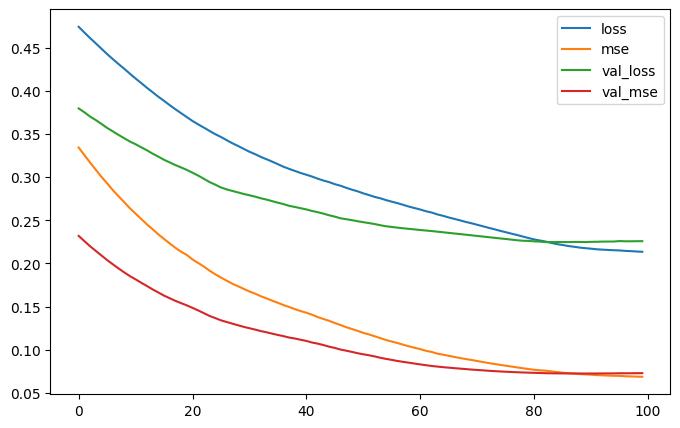

In [21]:
# proces uczenia
loss_curves = pd.DataFrame(history.history)
loss_curves.plot(figsize=(8, 5))

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [24]:
# train
print('TRAIN')
print(f'mean_absolute_error: {mean_absolute_error(y_train, train_predictions)}')
print(f'mean_squared_error: {mean_squared_error(y_train, train_predictions)}')
# test
print('TEST')
print(f'mean_absolute_error: {mean_absolute_error(y_test, predictions)}')
print(f'mean_squared_error: {mean_squared_error(y_test, predictions)}')

TRAIN
mean_absolute_error: 0.21333735321072975
mean_squared_error: 0.06838861276196866
TEST
mean_absolute_error: 0.22416697469968186
mean_squared_error: 0.07290715550256398


Interpretacja modelu

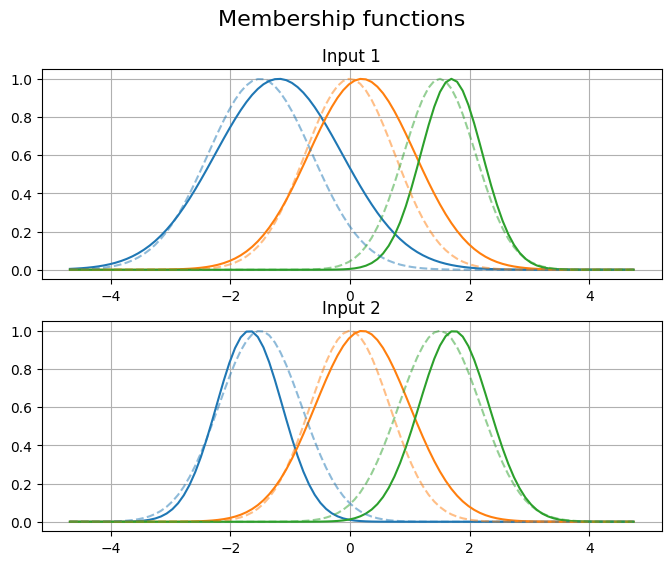

In [25]:
# eval model
fis.plotmfs(show_initial_weights=True)

In [26]:
# get premise parameters
premise_parameters = fis.model.get_layer('fuzzyLayer').get_weights()       # alternative
premise_parameters

# niebieski: input 1 - mu  |  input 2 - mu  
# pomaranczowy: input 1 - mu  |  input 2 - mu  | 
# niebieski: input 1 - mu  |  input 2 - mu  
# zielony: input 1 - mu  |  input 2 - mu  | 

# kolejna tablica - sigma

[array([[-1.1934832 , -1.6761858 ],
        [ 0.20165506,  0.21098042],
        [ 1.7028387 ,  1.7380699 ]], dtype=float32),
 array([[1.501002  , 0.7802369 ],
        [1.2641691 , 1.1201814 ],
        [0.73128664, 0.8295766 ]], dtype=float32)]

In [27]:
fis.model.summary()

Model: "myanfis"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputLayer (InputLayer)     [(16, 2)]                    0         []                            
                                                                                                  
 fuzzyLayer (FuzzyLayer)     (16, 3, 2)                   12        ['inputLayer[0][0]']          
                                                                                                  
 ruleLayer (RuleLayer)       (16, 9)                      0         ['fuzzyLayer[0][0]']          
                                                                                                  
 normLayer (NormLayer)       (16, 9)                      0         ['ruleLayer[0][0]']           
                                                                                            

y = ax1+ bx2 + c

In [28]:
# get consequence paramters
bias = fis.bias
weights = fis.weights
conseq_parameters = fis.model.get_layer('defuzzLayer').get_weights()       # alternatywa
conseq_parameters

[array([[-1.5490401 ,  0.7417024 , -0.8088483 , -0.6446421 ,  0.15276204,
          1.3564728 , -0.11050999, -1.129251  , -0.26781842]],
       dtype=float32),
 array([[-0.685031  , -1.0731833 , -0.77891344,  1.1530153 ,  1.3222077 ,
         -0.56050014, -1.2924632 ,  0.2816042 , -0.11829327],
        [-1.7871289 ,  0.31837967, -1.1976585 ,  0.44259083, -0.20200059,
          0.57392055, -0.09681963, -0.58049285,  1.3623929 ]],
       dtype=float32)]

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Wczytanie zbioru
Wczytaj dane do zmiennej df.
Wyświetl 3 pierwsze wiersze oraz inomracje rozmiarze zbioru (liczbę wierszy i kolumn)

In [30]:
df = pd.read_csv('winequality-red2.csv')
df.head(3)


,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [31]:
df.shape

(1500, 13)

Zapisz do zmiennej X kolumnę:
- volatile acidity
- density
Zapisz do zmiennej y kolumnę quality

In [32]:
X = df[['volatile acidity', 'density']]
y = df[['quality']]

## Podzial dane na zbiór treningowy (80%) i testowy (20%)
w tym celu wykorzystaj np. funkcję train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Standaryzacja
Przeprowadź standaryzację zmiennej. Możesz w tym celu wykorzystać np. funkcję StandardScaler

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#y_scaled = scaler.fit_transform(y_train)

In [35]:
scaler_y = StandardScaler()
scaler_y.fit(y_train)

y_train_std = scaler_y.transform(y_train)
y_test_std  = scaler_y.transform(y_test)

# MODEL

In [36]:
param = myanfis.fis_parameters(
    n_input = 2,
    n_memb = 2,
    batch_size = 100,
    memb_func = 'gaussian',
    optimizer = 'adam',
    loss = tf.keras.losses.MeanAbsoluteError(),
    n_epochs = 200
)

In [37]:
fis = myanfis.ANFIS(n_input=param.n_input,
                    n_memb=param.n_memb,
                    batch_size=param.batch_size,
                    memb_func=param.memb_func,
                    name='myanfis'
                    )

In [38]:
# compile model
fis.model.compile(optimizer=param.optimizer,
                  loss=param.loss,
                  metrics=['mse']  # ['mae', 'mse']
                  )

In [39]:
# fit model
history = fis.fit(X_train_scaled, y_train,
                  epochs=param.n_epochs,
                  batch_size=param.batch_size,
                  validation_data=(X_test, y_test),
                  # callbacks = [tensorboard_callback]  # for tensorboard
                  )

Epoch 1/200
12/12 [==============================] - 0s 7ms/step - loss: 6.3268 - mse: 43.4066 - val_loss: 4.8012 - val_mse: 23.8579
Epoch 2/200
12/12 [==============================] - 0s 2ms/step - loss: 6.2587 - mse: 42.6019 - val_loss: 4.7547 - val_mse: 23.4060
Epoch 3/200
12/12 [==============================] - 0s 2ms/step - loss: 6.1899 - mse: 41.8068 - val_loss: 4.7094 - val_mse: 22.9696
Epoch 4/200
12/12 [==============================] - 0s 2ms/step - loss: 6.1215 - mse: 41.0194 - val_loss: 4.6635 - val_mse: 22.5331
Epoch 5/200
12/12 [==============================] - 0s 2ms/step - loss: 6.0525 - mse: 40.2394 - val_loss: 4.6195 - val_mse: 22.1184
Epoch 6/200
12/12 [==============================] - 0s 2ms/step - loss: 5.9840 - mse: 39.4686 - val_loss: 4.5752 - val_mse: 21.7049
Epoch 7/200
12/12 [==============================] - 0s 2ms/step - loss: 5.9163 - mse: 38.7136 - val_loss: 4.5313 - val_mse: 21.2998
Epoch 8/200
12/12 [==============================] - 0s 2ms/step - lo

In [40]:
fis.model.summary()

Model: "myanfis"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputLayer (InputLayer)     [(100, 2)]                   0         []                            
                                                                                                  
 fuzzyLayer (FuzzyLayer)     (100, 2, 2)                  8         ['inputLayer[0][0]']          
                                                                                                  
 ruleLayer (RuleLayer)       (100, 4)                     0         ['fuzzyLayer[0][0]']          
                                                                                                  
 normLayer (NormLayer)       (100, 4)                     0         ['ruleLayer[0][0]']           
                                                                                            

<Axes: >

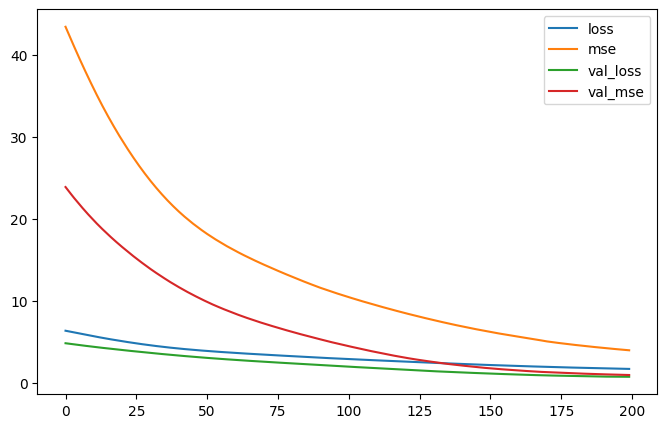

In [41]:
loss_curves = pd.DataFrame(history.history)
loss_curves.plot(figsize=(8, 5))

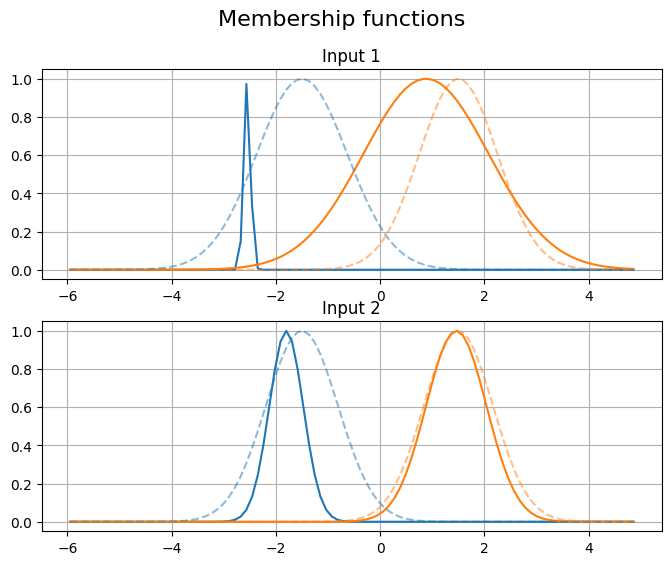

In [42]:
# eval model
import pandas as pd
fis.plotmfs(show_initial_weights=True)

## Predykcja

In [43]:
train_predictions = fis.model.predict(X_train_scaled, batch_size=param.batch_size)
predictions = fis.model.predict(X_test_scaled, batch_size=param.batch_size)

3/3 [==============================] - 0s 858us/step


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print(f'mean_absolute_error: {mean_absolute_error(y_train, train_predictions)}') # y_train jest krotką
print(f'mean_squared_error: {mean_squared_error(y_train, train_predictions)}')

mean_absolute_error: 1.665006160736084
mean_squared_error: 3.9249026775360107


In [45]:

print(f'mean_absolute_error: {mean_absolute_error(y_test, predictions)}')
print(f'mean_squared_error: {mean_squared_error(y_test, predictions)}')

mean_absolute_error: 1.7103809118270874
mean_squared_error: 3.9736945629119873
